# Bridge FT Integration Example

## Task: Pull in existing portfolio from Bridge System

In [2]:
# Bridge API
import requests
import json
import os
import urllib
import datetime
import requests
import numpy as np
import pandas as pd
import getpass

from tqdm.notebook import tqdm  # for use in notebook
# from tqdm import tqdm         # for use in scripts


class BridgeAPI:

    def __init__(self):
        self._username = None
        self._token = None
        self._refresh_token = None
        self.url_base = 'https://api.bridgeft.com'

    def login(self, username=None, password=None):
        if username is None:
            username = self.username
        else:
            self.username = username

        url = urllib.parse.urljoin(self.url_base, '/v2/oauth2/token')

        if password is None:
            password = getpass.getpass('Bridge Password')
        body = 'username={username}&password={password}&grant_type=password'.format(username=username, password=password)
        rs = requests.post(url, headers = {
            'Content-Type': 'application/x-www-form-urlencoded'
        }, data = body)
        if rs.ok:
            content = json.loads(rs.content)
            self._token = content['IdToken']
            self._refresh_token = content['RefreshToken']
        else:
            RuntimeError('{}: {}'.format(rs.status_code, rs.content))

    def auth_header(self):
        return {"Authorization": "Bearer {}".format(self._token)}
        
    def list_households(self):
        url = urllib.parse.urljoin(self.url_base, '/v2/account-management/household')        
        response = requests.request("GET", url, headers=self.auth_header())
        return json.loads(response.text).get('data',[])

    def list_accounts(self, household_id=None):
        url = urllib.parse.urljoin(self.url_base, '/v2/account-management/account/filter')        
        response = requests.request("POST", url, headers=self.auth_header(), json={
             "household_id": household_id
        })
        return json.loads(response.content).get('data',[])

    def get_custodian_positions(self, household_id, page=1, page_size=1000):
        url = urllib.parse.urljoin(
            self.url_base, 
            '/v2/data/custodian/position?household_id={household_id}&page={page}&page_size={page_size}'.format(
                household_id=household_id,
                page=page,
                page_size=page_size
            )
        )
        response = requests.request("GET", url, headers=bridge.auth_header())
        obj = json.loads(response.content)
        return pd.DataFrame(obj.get('data',[])), obj['has_next'], obj.get('total_pages', 1)

    def yield_custodian_positions(self, household_id, page=1, page_size=1000, ittr=None):        
        has_next = True        
        while has_next:
            positions, has_next, total_pages = self.get_custodian_positions(household_id, page=page, page_size=page_size)
            yield positions

            page += 1
            if ittr is None:
                ittr = tqdm(total=total_pages)
            ittr.update(1)


bridge = BridgeAPI()
bridge.login(username='skruzel@portformer.com', password=None)

Bridge Password········


In [3]:
households = pd.DataFrame(bridge.list_households()).set_index('id').sort_index()

display(households)

household_id = 2972 # Mike & Molly Matthews
assert household_id in households.index, "Mike & Molly Matthews id not found"

,short_name,close_date,name,managing_firm_id,is_account,entity_id,opening_date,benchmarks_id_list,is_household,firm_ids,object,inception_date,status
id,,,,,,,,,,,,,
2969,DEMMLH,None,Eddie & Emily Edwards Household,39,False,H-DEMMLH,2017-06-30,"[9394, 9581]",True,"[39, 315]",account_management.household,2016-12-31,110
2972,DEMGXH,None,Mike & Molly Matthews Household,39,False,H-DEMGXH,2017-06-30,"[9393, 9394, 10385]",True,"[39, 315]",account_management.household,2016-12-31,110
2974,DEMBBH,None,Jim & Janet Jones Household,39,False,H-DEMBBH,2017-06-30,"[9581, 9730]",True,"[39, 315]",account_management.household,2015-09-30,110
3236,DEMTTH,None,John & Jane Johnson Household,39,False,H-DEMTTH,2017-08-25,"[9394, 9581]",True,"[39, 315]",account_management.household,2016-11-18,110
11292,DEMSHH,None,Ryan & Jasmine Smith Household,39,False,H-DEMSHH,2018-12-31,"[9394, 9581]",True,"[39, 315]",account_management.household,2015-12-31,110
12281,HHDDTC,None,Demo Account Household,39,False,H-HHDDTC,2019-04-30,"[9394, 9581, 9882]",True,"[39, 315]",account_management.household,2019-04-30,110
17964,FLOCHE,None,Chelsea Flood Household,39,False,H-FLOCHE,None,[9394],True,"[39, 315]",account_management.household,None,110
20870,FADA877E,None,LUCA Test Household,39,False,H-FADA877E,2020-08-05,[],True,"[39, 315]",account_management.household,2020-08-05,110


In [4]:
# Get historical positions
data_columns = [
    'market_price',  'original_face',  'current_yield',  'accrued_income',  'quantity', 'market_value',  'cost'
]
date_columns = [
    'settle_date', 'as_of_date', 'purchase_date'
]
positions = pd.concat([p for p in bridge.yield_custodian_positions(household_id)], axis=0, ignore_index=True)
positions.loc[:, data_columns] = positions.loc[:, data_columns].astype(np.float)

for c in date_columns:
    positions.loc[:, c] = positions.loc[:, c].apply(
        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d') if x is not None else None
    )

<AxesSubplot:xlabel='as_of_date'>

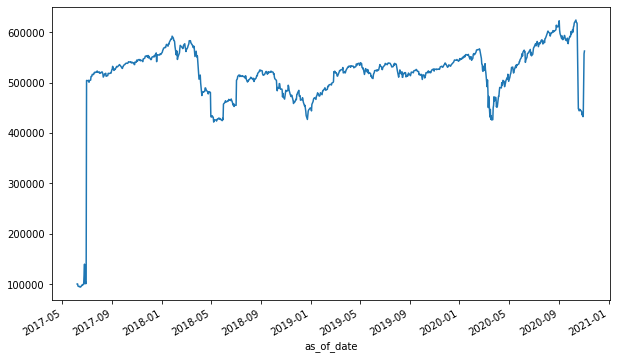

In [5]:
market_values = pd.pivot_table(
    positions, 
    index='as_of_date', 
    columns=['security_id','symbol'], 
    values='market_value'
).sort_index()

market_values.sum(axis=1).plot(figsize=(10, 6))

In [6]:
latest_as_of_date = positions.as_of_date.max()
latest_as_of_date

Timestamp('2020-11-03 00:00:00')

In [7]:
latest_positions = positions.loc[positions.as_of_date == latest_as_of_date]
latest_positions

,market_value,market_price,accrued_income,account_id,symbol,purchase_date,current_yield,quantity,settle_date,household_id,as_of_date,cost,object,id,cusip,original_face,security_id
71919,214297.03,100.00,0.0,None,CASH-1,None,0.00,214297.03,None,2972,2020-11-03,214297.03,data.custodian.position,4458688102,,0.0,5217
71920,1664.30,15.13,0.0,None,ANF,2018-05-10 00:00:00,0.00,110.00,2018-05-14 00:00:00,2972,2020-11-03,2881.35,data.custodian.position,4458688103,002896207,0.0,163
71921,2347.20,260.80,0.0,None,ABMD,2018-05-10 00:00:00,0.00,9.00,2018-05-14 00:00:00,2972,2020-11-03,3312.16,data.custodian.position,4458688104,003654100,0.0,4926
71922,5448.24,454.02,0.0,None,ADBE,2018-05-10 00:00:00,0.00,12.00,2018-05-14 00:00:00,2972,2020-11-03,2893.03,data.custodian.position,4458688105,00724F101,0.0,1768
71923,1970.46,36.49,0.0,None,BZUN,2018-05-10 00:00:00,0.00,54.00,2018-05-14 00:00:00,2972,2020-11-03,2730.25,data.custodian.position,4458688106,06684L103,0.0,897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72031,709.26,118.21,0.0,None,WING,2018-05-10 00:00:00,0.47,6.00,2018-05-14 00:00:00,2972,2020-11-03,321.53,data.custodian.position,4458691718,974155103,0.0,1832
72032,2618.00,38.50,0.0,None,WWE,2018-05-10 00:00:00,1.25,68.00,2018-05-14 00:00:00,2972,2020-11-03,2952.84,data.custodian.position,4458691719,98156Q108,0.0,3837
72033,269.50,38.50,0.0,None,WWE,2018-05-10 00:00:00,1.25,7.00,2018-05-14 00:00:00,2972,2020-11-03,303.97,data.custodian.position,4458693571,98156Q108,0.0,3837
72034,5962.32,114.66,0.0,None,ZEN,2018-05-10 00:00:00,0.00,52.00,2018-05-14 00:00:00,2972,2020-11-03,2954.97,data.custodian.position,4458693572,98936J101,0.0,16877


In [8]:
# Get latest prices
market_price = latest_positions.groupby(
    ['security_id','symbol']
)['market_price'].mean()
market_price.name = 'market_price'

# Get lot counts
latest_lot_counts = latest_positions.groupby(
    ['security_id','symbol']
)['quantity'].count()
latest_lot_counts.name = 'lot_counts'
latest_lot_counts

latest_holdings = latest_positions.groupby(
    ['security_id','symbol']
)[['quantity', 'market_value', 'cost']].sum().sort_values(['market_value'])

latest_holdings = latest_holdings.join(latest_lot_counts, how='left').join(market_price, how='left')

display(latest_holdings)

,,quantity,market_value,cost,lot_counts,market_price
security_id,symbol,,,,,
5578,TLRDQ,91.00,6.82,2885.38,1,0.07
16870,DNRCQZ,765.00,22.95,2889.54,1,0.03
10800,WLL--Z,68.00,38.52,3212.69,2,0.57
1756,HFC,43.00,819.15,2916.10,1,19.05
5860,TWOU,34.00,1279.76,3229.59,2,37.64
16872,HRTX,96.00,1560.96,2903.05,1,16.26
1484,GES,123.00,1583.01,2919.38,1,12.87
10455,SPYV,52.00,1600.04,1622.21,4,30.77
163,ANF,110.00,1664.30,2881.35,1,15.13


## Problematic LUCA HOLDING API CALL

This should return holdings but it errors

In [9]:
url = "https://api.bridgeft.com/v2/data/luca/holding"

headers = {"Authorization": "Bearer {}".format(bridge._token)}
response = requests.request("GET", url, headers=bridge.auth_header())

print(response.text)

{"message": "Internal server error"}


## TODO: pull in details for only a specific `account number` and `benchmark`

In [10]:
benchmarks_id = 10312
account_number = 95687553